<div style="display: flex; justify-content: center; align-items: center;">
<p align="center">
<img src="Capa_c.jpeg" style="width:250px;height:250px" alt='imagem do daniel'>
</p>

<div style="margin-left: 20px;">
<h1 style="font-family: times new roman;">TechTrinity</h1>
<p style="margin-bottom: 5px;">Trabalho Final de Redes Neurais</p>
<p style="margin-bottom: 5px;">INTEGRANTES: Eric Leandro, Samuel Araujo e Daniel Carrasco </p>
<p style="margin-bottom: 5px;">DISCIPLINA: Redes Neurais e Algoritmos Genéticos</p>
<p style="margin-bottom: 5px;">MESTRE: Daniel Cassar</p>

</div>

## Definições

In [24]:
'''IMPORTS'''

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [25]:
'''FUNÇÕES'''

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.title('Gráfico de Resíduos')
    plt.xlabel('Valores Previstos')
    plt.ylabel('Resíduos')
    plt.grid(True)
    plt.show()

In [27]:
'''Redes Neural'''

class NeuralNetworkRegressor(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, learning_rate=0.1, dropout_prob=0.3, momentum=0.8):
        super(NeuralNetworkRegressor, self).__init__()
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.dropout_prob = dropout_prob
        self.momentum = momentum
        
        # Primeira camada oculta
        self.hidden_layer1 = nn.Linear(input_size, hidden_size1)
        self.hidden_activation1 = nn.ReLU()
        
        # Segunda camada oculta
        self.hidden_layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.hidden_activation2 = nn.ReLU()
        
        # Camada de saída
        self.output_layer = nn.Linear(hidden_size2, 1)
        
        # Dropout
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # Otimizador com Momento
        self.optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)
        
        # Função de perda (Mean Squared Error)
        self.criterion = nn.MSELoss()
    
    def forward(self, x):
        # Primeira camada oculta
        hidden_output1 = self.hidden_layer1(x)
        hidden_output1 = self.hidden_activation1(hidden_output1)
        
        # Dropout (apenas durante o treinamento)
        if self.training:
            hidden_output1 = self.dropout(hidden_output1)
        
        # Segunda camada oculta
        hidden_output2 = self.hidden_layer2(hidden_output1)
        hidden_output2 = self.hidden_activation2(hidden_output2)
        
        # Dropout (apenas durante o treinamento)
        if self.training:
            hidden_output2 = self.dropout(hidden_output2)
        
        # Camada de saída
        output = self.output_layer(hidden_output2)
        return output
    
    def train_model(self, X_train, y_train, epochs):
        for epoch in range(epochs):
            # Ativa o modo de treinamento
            self.train()
            
            # Realiza a propagação direta
            outputs = self(X_train)
            
            # Calcula a perda
            loss = self.criterion(outputs, y_train)
            
            # Retropropagação e atualização dos pesos
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Mostra a perda a cada 100 épocas
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')
                
    def predict(self, X, num_samples=10):
        """
        Realiza a previsão com base nos dados de entrada fornecidos usando Monte Carlo Dropout.

        Args:
            X (torch.Tensor): Os dados de entrada para prever.
            num_samples (int): O número de amostras de dropout a serem usadas (default 10).

        Returns:
            torch.Tensor: A média das previsões feitas com diferentes amostras de dropout.
        """
        # Ativa o modo de avaliação
        self.eval()
        
        # Lista para armazenar as previsões
        predictions = []
        
        # Realiza múltiplas previsões com diferentes amostras de dropout
        for _ in range(num_samples):
            with torch.no_grad():
                outputs = self(X)
                predictions.append(outputs)
        
        # Calcula a média das previsões
        predictions = torch.stack(predictions).mean(dim=0)
        return predictions


## Dados

In [28]:
'''Pegando os dados'''

# Carregando o arquivo CSV para o teste
minerais_treino = pd.read_csv('Mineral_Dataset_Supplementary_Info.csv')

# Transformando o dataset em um Dataframe pandas
df_treino = pd.DataFrame(minerais_treino) 

# Mostrando o Dataframe
print("Dataset de treino:")
display(df_treino)

# Carregando o arquivo CSV para o teste
minerais_teste = pd.read_csv('Artificial_Crystals_Dataset.csv')

# Transformando o dataset em um Dataframe pandas
df_teste = pd.DataFrame(minerais_teste) 

# Mostrando o Dataframe
print("Dataset de teste:")
display(df_teste)

Dataset de treino:


,Unnamed: 0,Hardness,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,0,2.3,110.0,23.000000,36.666667,2.666667,82.598467,8.504133,2.146667,2.006667,1.253333,0.456803,7.666667
1,1,5.5,406.0,30.472136,9.902439,4.682927,19.813180,11.456151,2.700244,1.676829,0.868293,0.522909,0.743223
2,2,5.5,406.0,30.472464,10.410256,4.923077,20.931371,11.541405,2.753590,1.703846,0.894359,0.497498,0.781345
3,3,5.5,476.0,61.142136,11.609756,4.682927,23.659644,11.487395,2.763659,1.714634,0.848780,0.519474,1.491272
4,4,5.5,476.0,61.142464,12.205128,4.923077,24.975089,11.574251,2.820256,1.743590,0.873846,0.493887,1.567755
...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,625,3.8,46.0,9.133000,23.000000,4.000000,48.719500,9.877100,2.115000,1.905000,1.120000,0.478880,4.566500
618,626,4.5,86.0,6.674328,14.333333,5.166667,30.645954,11.862733,2.861667,1.700000,0.901667,0.487172,1.112388
619,628,4.0,38.0,7.134332,19.000000,4.000000,40.689515,11.506150,2.545000,1.765000,0.920000,0.479405,3.567166
620,629,7.5,86.0,8.841328,14.333333,5.000000,30.550687,11.543000,2.831667,1.735000,0.890000,0.489507,1.473555


Dataset de teste:


,Unnamed: 0,Formula,Crystal structure,Hardness (Mohs),allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,0,MnTeMoO6,tetragonal,4.50,167.000,23.907992,18.555556,5.000000,41.609136,11.693844,2.938889,1.711111,0.884444,0.477830,2.656444
1,1,MgH2,tetragonal,4.00,14.000,1.740168,4.666667,1.333333,8.773227,11.614333,1.903333,1.310000,0.680000,0.825990,0.580056
2,2,CO(NH2)2C4H6O5,monoclinic,2.50,102.000,8.511159,4.434783,3.304348,8.440584,13.176622,2.672609,1.379130,0.530870,0.713850,0.370050
3,3,GaPO4,trigonal,5.50,78.000,8.109328,13.000000,5.333333,27.448814,11.826400,2.960000,1.625000,0.813333,0.488163,1.351555
4,4,Ga3PO7,trigonal,6.50,164.000,19.921324,14.909091,5.090909,32.012361,11.255573,2.881818,1.640909,0.841818,0.483480,1.811029
5,5,LiB3O5,orthorhombic,6.50,58.000,7.650660,6.444444,4.444444,13.261239,10.930689,2.700000,1.686667,0.780000,0.479962,0.850073
6,6,BiB3O6,monoclinic,5.75,146.000,16.864992,14.600000,5.000000,33.739258,11.388810,2.866000,1.695000,0.786000,0.478464,1.686499
7,7,K2Al2B2O7,trigonal,6.00,130.000,11.871324,10.000000,4.307692,20.443453,10.198131,2.540000,1.820000,0.972308,0.489274,0.913179
8,8,Nd0.02GdLa0.16Ca4O(BO3)3,monoclinic,6.42,249.320,22.345960,13.713971,4.365237,29.432344,10.598482,2.525787,1.813894,0.992739,0.487604,1.229151
9,9,Nd0.02GdLa0.33Ca4O(BO3)3,monoclinic,6.35,259.010,23.392140,14.114986,4.343324,30.446537,10.551961,2.512578,1.819602,1.001515,0.486888,1.274776


In [29]:
'''Tratando os dados'''

# Retirando colunas desinteressantes
df_teste = df_teste.drop(['Unnamed: 0', 'Crystal structure', 'Formula'], axis=1)

# Trocando o nome de uma coluna para facilitar o codigo
df_teste.rename(columns={'Hardness (Mohs)': 'Hardness'}, inplace=True)

# Retirando valores nan
df_teste = df_teste.dropna()

# Ajustando o index
df_teste = df_teste.reset_index(drop=True)

df_teste # Mostrando nova tabela

,Hardness,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,4.50,167.000,23.907992,18.555556,5.000000,41.609136,11.693844,2.938889,1.711111,0.884444,0.477830,2.656444
1,4.00,14.000,1.740168,4.666667,1.333333,8.773227,11.614333,1.903333,1.310000,0.680000,0.825990,0.580056
2,2.50,102.000,8.511159,4.434783,3.304348,8.440584,13.176622,2.672609,1.379130,0.530870,0.713850,0.370050
3,5.50,78.000,8.109328,13.000000,5.333333,27.448814,11.826400,2.960000,1.625000,0.813333,0.488163,1.351555
4,6.50,164.000,19.921324,14.909091,5.090909,32.012361,11.255573,2.881818,1.640909,0.841818,0.483480,1.811029
5,6.50,58.000,7.650660,6.444444,4.444444,13.261239,10.930689,2.700000,1.686667,0.780000,0.479962,0.850073
6,5.75,146.000,16.864992,14.600000,5.000000,33.739258,11.388810,2.866000,1.695000,0.786000,0.478464,1.686499
7,6.00,130.000,11.871324,10.000000,4.307692,20.443453,10.198131,2.540000,1.820000,0.972308,0.489274,0.913179
8,6.42,249.320,22.345960,13.713971,4.365237,29.432344,10.598482,2.525787,1.813894,0.992739,0.487604,1.229151
9,6.35,259.010,23.392140,14.114986,4.343324,30.446537,10.551961,2.512578,1.819602,1.001515,0.486888,1.274776


In [30]:
'''Separando Features e Targets'''

# Definindo Features
FEATURES = [ 'density_Total',  'allelectrons_Average',
            'val_e_Average',  'atomicweight_Average',  'ionenergy_Average',
            'el_neg_chi_Average',  'R_cov_element_Average',
             'density_Average']

# Definindo Targets
TARGET = 'Hardness'

# Separando dados para o treino
X_train = df_treino[FEATURES]
Y_train = df_treino[TARGET]

# Separando dados para teste
X_test = df_teste[FEATURES]
Y_test = df_teste[TARGET]

In [31]:
'''Normalizando os dados'''

# Criando um objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajuste o scaler aos dados e transforme-os
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [32]:
'''Transformando em tensores'''

# Tensores do treino
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

# Tensores do teste
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Ajustando dimensões dos targets
Y_train_tensor_dimensionado = Y_train_tensor.view(-1,1)
Y_test_tensor_dimensionado = Y_test_tensor.view(-1,1)

## Montando a rede

In [33]:
'''Treinando a rede'''

# Parâmetros da rede neural
input_size = 8
hidden_size1 = 32
hidden_size2 = 16
epochs = 2000
learning_rate = 0.01

# Criação e treinamento da rede neural
neural_net = NeuralNetworkRegressor(input_size, hidden_size1, hidden_size2, learning_rate)
neural_net.train_model(X_test_scaled_tensor, Y_test_tensor_dimensionado, epochs)

Epoch [100/2000], Loss: 1.9809015989303589
Epoch [200/2000], Loss: 1.7534053325653076
Epoch [300/2000], Loss: 1.3817124366760254
Epoch [400/2000], Loss: 1.3161354064941406
Epoch [500/2000], Loss: 1.5291287899017334
Epoch [600/2000], Loss: 1.302701473236084
Epoch [700/2000], Loss: 1.3590104579925537
Epoch [800/2000], Loss: 1.4622859954833984
Epoch [900/2000], Loss: 1.2770531177520752
Epoch [1000/2000], Loss: 1.2680327892303467
Epoch [1100/2000], Loss: 1.5235943794250488
Epoch [1200/2000], Loss: 1.1474595069885254
Epoch [1300/2000], Loss: 1.1850659847259521
Epoch [1400/2000], Loss: 1.6281428337097168
Epoch [1500/2000], Loss: 1.476349949836731
Epoch [1600/2000], Loss: 1.3800384998321533
Epoch [1700/2000], Loss: 1.171048879623413
Epoch [1800/2000], Loss: 1.1606072187423706
Epoch [1900/2000], Loss: 1.3249151706695557
Epoch [2000/2000], Loss: 1.0173758268356323


In [40]:
'''Testando a rede'''

predictions = neural_net.predict(X_test_scaled_tensor)
print("Predictions:")
print(predictions)

Predictions:
tensor([[4.8216],
        [4.1869],
        [4.0880],
        [6.0491],
        [6.4181],
        [6.6309],
        [5.9201],
        [6.3331],
        [5.6215],
        [5.4197],
        [5.7954],
        [5.1386],
        [6.0616],
        [5.8354],
        [6.6309],
        [3.4467],
        [4.0766],
        [5.0134],
        [5.0134],
        [6.6267],
        [5.1069],
        [5.6344],
        [4.8050],
        [5.1033],
        [4.8609],
        [6.6309],
        [6.6309],
        [6.0395],
        [6.3006],
        [5.0261],
        [5.3325],
        [6.6309],
        [4.7890],
        [4.0766],
        [6.4475],
        [5.5484],
        [6.6309],
        [6.4149],
        [5.0433],
        [6.3727],
        [5.0220],
        [6.0519],
        [6.6309],
        [6.6309],
        [4.3292],
        [4.4824],
        [4.1907],
        [5.9288],
        [5.1119],
        [4.2254],
        [4.3093],
        [4.2655]])


MSE: 0.9077023863792419
MAE: 0.7555914521217346
RMSE: 0.9527341723442078
R²: 0.6012232272722429


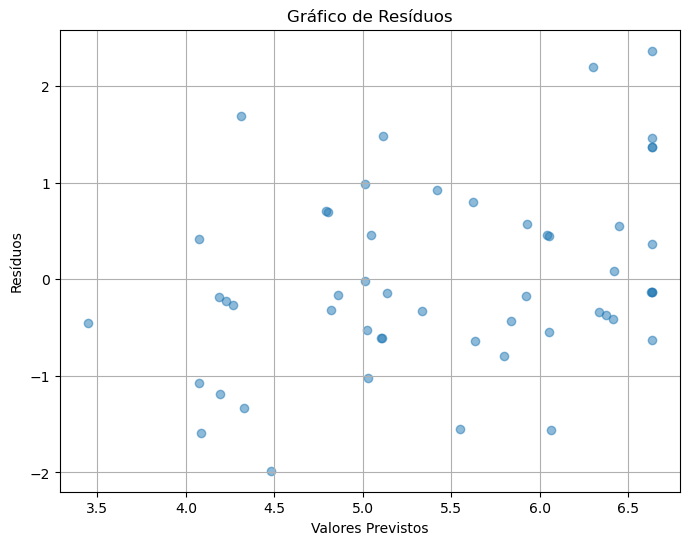

In [39]:
'''Calculando erros'''

# Calculando as métricas
mse = mean_squared_error(Y_test_tensor_dimensionado, predictions)
mae = mean_absolute_error(Y_test_tensor_dimensionado, predictions)
rmse = root_mean_squared_error(Y_test_tensor_dimensionado, predictions)
r2 = r_squared(Y_test_tensor_dimensionado, predictions)

# Exibindo os resultados
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Plotando o gráfico de resíduos
plot_residuals(Y_test_tensor_dimensionado, predictions)

